# Exercise 3: Linear Prediction

In [90]:
import librosa
import numpy as np
from scipy.linalg import solve_toeplitz
from scipy.signal import get_window, freqz, lfilter
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 4)

In [91]:
# "Import" functions from exercise 1

import requests

gist = requests.get(
    "https://gist.githubusercontent.com/iibrahimli/3c50f73020c78aeee1de68ae5a0ba5e7/raw/import_funcs.py"
).text
print("Downloaded import_funcs.py")
exec(gist)

import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "plot_signal",
    ],
)

Downloaded import_funcs.py
Found exercise1.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise1/exercise1.ipynb
Executed function plot_signal
Successfully imported functions: ['plot_signal']


## 1. Load `speech1.wav`

In [92]:
s, fs = librosa.core.load("../Exercise2/Audio/speech1.wav")
s.shape, fs

((62658,), 22050)

## 2. Select voiced and unvoiced segments

In [93]:
segment_len = int(32 / 1000 * fs) # 32 ms
voiced_start = int(400 / 1000 * fs) # 400 ms
unvoiced_start = int(550 / 1000 * fs) # 550 ms

voiced_s = s[voiced_start:voiced_start+segment_len]
unvoiced_s = s[unvoiced_start:unvoiced_start+segment_len]

# Apply the Hann window to the voiced and unvoiced segments
window = get_window("hann", segment_len)
voiced_s = voiced_s * window
unvoiced_s = unvoiced_s * window

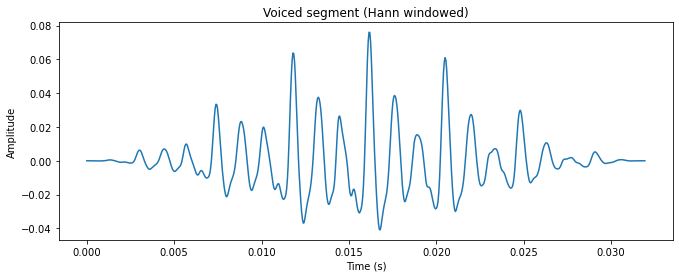

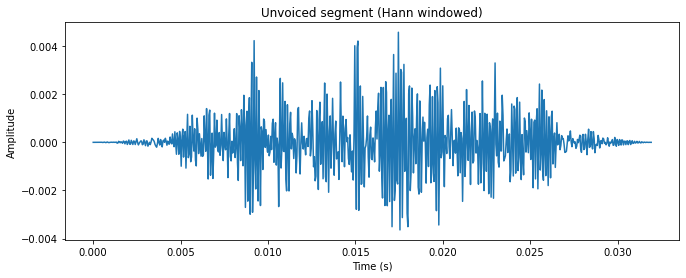

In [94]:
plot_signal(voiced_s, fs, "Voiced segment (Hann windowed)")
plot_signal(unvoiced_s, fs, "Unvoiced segment (Hann windowed)")

## 3. Compute LP coefficients

In [95]:
M = 12 # LPC order

In [96]:
def estimate_filter(segment, M=12):
    """Solve Toeplitz system, returns vector a of LPC coefficients"""
    # Estimate autocorrelation
    r = np.correlate(segment, segment, mode="full")
    r = r[len(r) // 2:]

    # Take the first M+1 elements of the autocorrelation vector
    r = r[:M+1]

    # Solve the Toeplitz system
    a = solve_toeplitz((-r[:-1], -r[:-1]), r[1:])
    return a

In [97]:
a_voiced = estimate_filter(voiced_s, M)
a_voiced

array([ -5.05098356,  12.59926553, -21.8016928 ,  30.83992439,
       -37.81599979,  39.81203095, -35.50185791,  27.1173312 ,
       -17.84801738,   9.5636052 ,  -3.57398394,   0.66963117])

In [98]:
a_unvoiced = estimate_filter(unvoiced_s, M)
a_unvoiced

array([ -2.08581525,   4.20923977,  -6.52346923,   8.8414268 ,
       -10.20188208,  10.6117754 ,  -9.45941963,   7.63653992,
        -5.19440093,   3.07560183,  -1.37227139,   0.53358707])

## 4. Frequency response

### a) Plot the frequency response of the LP filter

In [132]:
def plot_freq_response(s, fs, M, title, fig=None, axs=None, color=None):
    """Plots the frequency response of the filter"""

    a = estimate_filter(s, M)
    w, h = freqz(1, np.concatenate(([1], a)), len(s), whole=True, fs=fs)

    if axs is None or fig is None:
        fig, axs = plt.subplots(1, 2)

    axs[0].plot(w, 20 * np.log10(np.abs(h)), color=color)
    axs[0].set_title("Magnitude response")
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Magnitude (dB)")
    axs[0].grid()

    axs[1].plot(w, np.angle(h), color=color)
    axs[1].set_title("Phase response")
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Phase (rad)")
    axs[1].grid()

    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

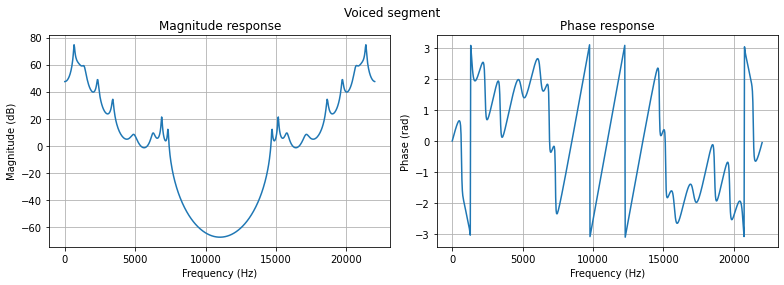

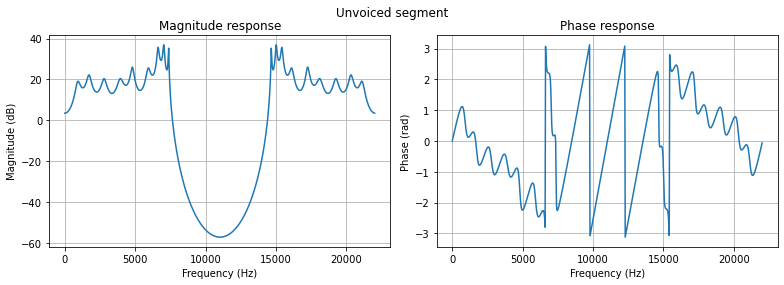

In [133]:
plot_freq_response(voiced_s, fs, M, "Voiced segment")
plot_freq_response(unvoiced_s, fs, M, "Unvoiced segment")

### b) Using `np.concatenate(([1], a))`

We used `np.concatenate(([1], a))` instead of just `a` because the filter coefficients are the coefficients of the denominator of the transfer function, which is $1 + a_1 z^{-1} + a_2 z^{-2} + \dots + a_p z^{-p}$. The additional $1$ is first term in the denominator.

## 5. DFT of windowed segments

In [134]:
def plot_dft(s, fs, title):
    """Plots the DFT of the signal"""
    S = np.fft.rfft(s)
    freqs = np.fft.rfftfreq(len(s), 1 / fs)

    a = estimate_filter(s, M)
    w, h = freqz(1, np.concatenate(([1], a)), len(s), fs=fs)

    fig, ax = plt.subplots(1, 1)
    ax.plot(freqs, 20 * np.log10(np.abs(S)), label="S(z)")
    ax.plot(w, 20 * np.log10(np.abs(h)), color="red", label="H(z)")
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude (dB)")
    ax.grid()
    ax.legend()

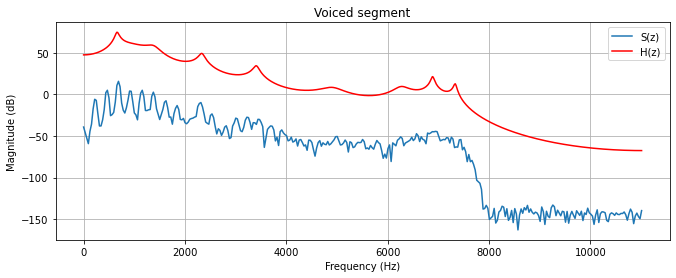

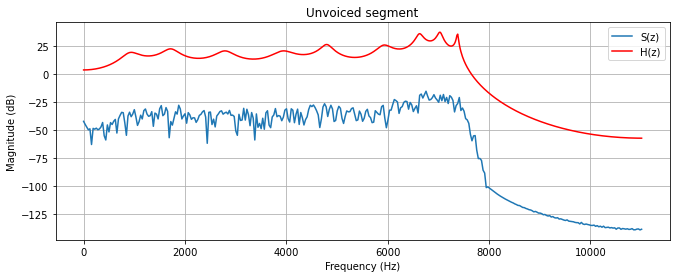

In [135]:
plot_dft(voiced_s, fs, "Voiced segment")
plot_dft(unvoiced_s, fs, "Unvoiced segment")

## 6. Residual signal

### a) Compute and plot the residual signal

In [136]:
def plot_residual(s, a, M, title):
    """Plots the signal and residual signal"""
    e = lfilter(np.concatenate(([1], a)), 1, s)

    fig, ax = plt.subplots(1, 1)
    ax.plot(s, label="Signal")
    ax.plot(e, color="red", label="Residual signal")
    ax.set_title(title)
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Amplitude")
    ax.grid()
    ax.legend()

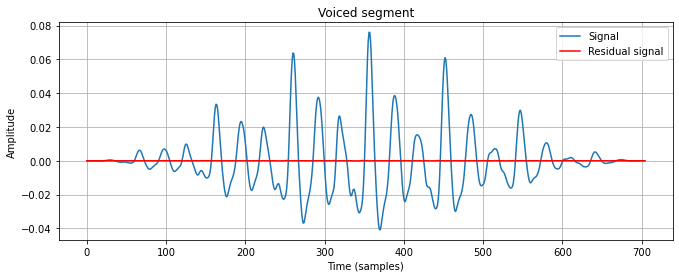

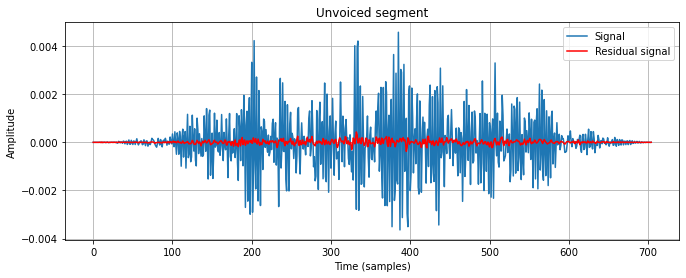

In [137]:
plot_residual(voiced_s, estimate_filter(voiced_s, M), M, "Voiced segment")
plot_residual(unvoiced_s, estimate_filter(unvoiced_s, M), M, "Unvoiced segment")

### b) Differences in `e` between the voiced and unvoiced segments

The residual for the voiced segment does not contain any noise since inverse filtering reconstructs the sha comb from the excitation signal. The residual for the unvoiced segment contains noise since the excitation signal is white noise.

### c) Why `lfilter(np.concatenate(([1], a)), 1, s)` yields the residual signal

We are passing the [1, *a] array as the numerator and 1 as the denominator, which is the inverse filter.

## 7. Modifying H

### a) Why are the log amplitudes of H and S not on the same level?

Some energy comes from the residual signal, which is not included in the spectrum of the LP filter.

### b) Modifying H to achieve a better match (experiment with the energy of the residual `e`)

In [138]:
# Compute the energy of the residual signal
def energy(s):
    return np.sum(s ** 2)

In [139]:
# TODO

## 8. Different order `M`

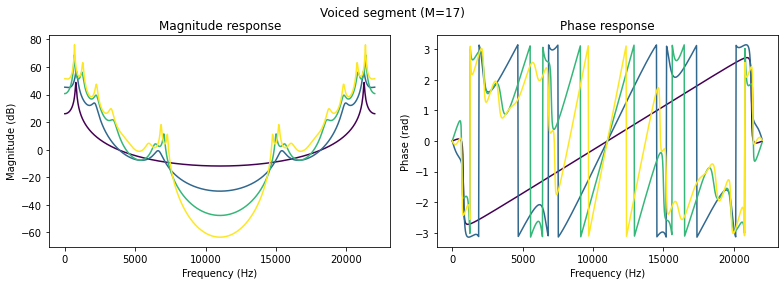

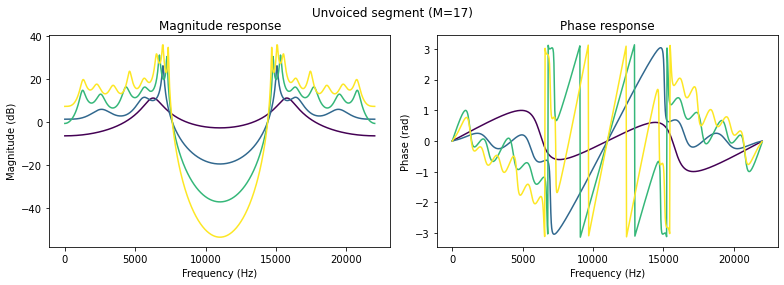

In [145]:
fig_voiced, axs_voiced = plt.subplots(1, 2)
fig_unvoiced, axs_unvoiced = plt.subplots(1, 2)

cmap = plt.get_cmap("viridis")

lpc_order = list(range(2, 21, 5))

for i, M in enumerate(lpc_order):
    a_voiced = estimate_filter(voiced_s, M)
    a_unvoiced = estimate_filter(unvoiced_s, M)

    plot_freq_response(
        voiced_s,
        fs,
        M,
        f"Voiced segment (M={M})",
        fig_voiced,
        axs_voiced,
        color = cmap(i / (len(lpc_order) - 1)),
    )
    plot_freq_response(
        unvoiced_s,
        fs,
        M,
        f"Unvoiced segment (M={M})",
        fig_unvoiced,
        axs_unvoiced,
        color = cmap(i / (len(lpc_order) - 1)),
    )

TODO explanation how H(z) changes with M

## 9. Pre-emphasis

### a) Computing LP coefficients for pre-emphasized signal

In [108]:
# TODO

### b) Advantages of pre-emphasizing the speech signal

TODO